In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cuda


In [3]:
def generate_cx_sigm(x):
    # rand_btw_7-30 * {-1, 1}
    c1 = (torch.rand(len(x), 1) * 23 + 7) #* torch.from_numpy(np.random.choice([-1, 1], (n, 1)))  # c1 for steepness
    c2 = 0.5  # c2 midpoint
    
    data = 1/(1 + torch.exp(-c1 * (x-c2)))
    return data


def generate_reverse_cx_sigm(x):
    return 1-generate_cx_sigm(x)


def generate_sin(x, amp=1, omega=1, eps=0.1):
#     r1 = torch.rand(1)*(eps*2)+(1-eps)
#     r2 = torch.rand(1)*(eps*2)+(1-eps)
#     r3 = torch.rand(1)*(eps*2)+(1-eps)
#     return r1*amp*torch.sin(x*omega+r2)+r3
    return torch.sin(x*torch.pi)


def generate_cos(x, amp=1, omega=1, eps=0.1):
#     r1 = torch.rand(1)*(eps*2)+(1-eps)
#     r2 = torch.rand(1)*(eps*2)+(1-eps)
#     r3 = torch.rand(1)*(eps*2)+(1-eps)
#     return r1*amp*torch.cos(x*omega+r2)+r3
    return torch.cos((0.5+x)*torch.pi)+1


def generate_chainsaw(x, amp=1, mod=0.5, eps=0.1):
    r1 = torch.rand(1)*(eps*2)+(1-eps)
    r2 = torch.rand(1)*(eps*2)+(1-eps)
    r3 = torch.rand(1)*(eps*2)+(1-eps)
#     return 1.8*(r1*amp*((x+r2) % (mod))+r3-amp/4)-1.5
    return 1.8*(amp*(x%mod)-amp/4)+0.5


def generate_reverse_chainsaw(x, amp=1, mod=0.5, eps=0.1):
    r1 = torch.rand(1)*(eps*2)+(1-eps)
    r2 = torch.rand(1)*(eps*2)+(1-eps)
    r3 = torch.rand(1)*(eps*2)+(1-eps)
#     return 1.8*(-r1*amp*((x+r2) % (mod))+r3+amp/4) -1.5
    return 1.8*(-amp*(x%mod)+amp/4)+0.5


t_steps = 200
num_demos = 100
num_classes = 4
num_indiv = int(num_demos/num_classes)
num_val = 20
num_val_indiv = int(num_val/num_classes)
noise_clip = 0.0
dx, dy = 1, 1
x = torch.linspace(0, 1, t_steps).repeat(num_indiv, 1)
y = torch.zeros(num_demos, t_steps, dy)

generator_functions = [generate_sin, generate_cos, generate_cx_sigm, generate_reverse_cx_sigm]

for i in range(num_classes):
    noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0) - noise_clip
    y[i*num_indiv:(i+1)*num_indiv] = torch.unsqueeze(generator_functions[i](x) + noise, 2)

x = torch.unsqueeze(x.repeat(num_classes, 1), 2)
print("X:", x.shape, "Y:", y.shape)

path = "."

#######################################

vx = torch.linspace(0, 1, t_steps).repeat(num_val_indiv, 1)
vy = torch.zeros(num_val, t_steps, dy)

for i in range(num_classes):
    vnoise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0) - noise_clip
    vy[i*num_val_indiv:(i+1)*num_val_indiv] = torch.unsqueeze(generator_functions[i](vx) + vnoise, 2)

vx = torch.unsqueeze(vx.repeat(num_classes, 1), 2)

print("vX:", vx.shape, "vY:", vy.shape)

X: torch.Size([100, 200, 1]) Y: torch.Size([100, 200, 1])
vX: torch.Size([20, 200, 1]) vY: torch.Size([20, 200, 1])


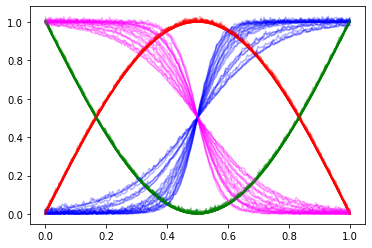

In [4]:
for i in range(num_indiv):
    plt.plot(x[i, :, 0], y[i, :, 0], 'r', alpha=0.3)
    plt.plot(x[i+num_indiv, :, 0], y[i+num_indiv, :, 0], 'g', alpha=0.3)
    plt.plot(x[i+2*num_indiv, :, 0], y[i+2*num_indiv, :, 0], 'b', alpha=0.3)
    plt.plot(x[i+3*num_indiv, :, 0], y[i+3*num_indiv, :, 0], 'magenta', alpha=0.3)
plt.show()

In [5]:
n_max = 10

def sample_training_demonstration():    
    rand_traj_ind = np.random.randint(0, num_demos)
    n = np.random.randint(1, n_max+1)

    rand_traj = y[rand_traj_ind, :, :]

    observation_indices = np.random.choice(np.arange(t_steps), n+1, replace=False) # n+1: +1 is for sampling the target
    
    observations = torch.cat((rand_traj[observation_indices[:-1], :], 
                              x[rand_traj_ind, observation_indices[:-1], :]), 1)
    targetX = torch.unsqueeze(torch.Tensor(x[rand_traj_ind, observation_indices[-1], :]), 0)
    targetY = torch.unsqueeze(torch.Tensor(rand_traj[observation_indices[-1], :]), 0)
    
    if device.type == 'cuda':
        return observations.float().cuda(), targetX.float().cuda(), targetY.float().cuda()
    else:
        return observations.float(), targetX.float(), targetY.float()


def get_validation_demonstration(ind):
    x = vx[ind, :, :]
    y = vy[ind, :, :]
    
    if device.type == 'cuda':
        return x.float().cuda(), y.float().cuda()
    else:
        return x, y

In [6]:
from torch.distributions import Categorical


class BCNP(nn.Module):
    def __init__(self, in_shape, num_decoders):
        super(BCNP, self).__init__()
        
        self.num_decoders = num_decoders
        dx, dy = in_shape[0], in_shape[1]
        
        dz = 128
        dzt = dz+dx
        
        self.encoder = nn.Sequential(
            nn.Linear(dx+dy, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, dz)
        )
        
        self.gate = nn.Sequential(
            nn.Linear(dz, self.num_decoders),
            nn.Softmax(dim=-1)
        )
        
        decoders = []
        for i in range(self.num_decoders):
            decoders.append(nn.Sequential(
                nn.Linear(dzt, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, dy*2)
                )
            )
            
        self.decoders = nn.ModuleList(decoders)
        

    def forward(self, observations, target):
        z_out = self.encoder(observations)
        z = torch.mean(z_out, dim=0)

        zs = z.repeat(target.shape[0], 1).to(device)  # repeating the same z for each target
        z_target = torch.cat((zs, target), 1)
        
        dec_out = torch.zeros(self.num_decoders, dy*2).float().to(device)
        for i in range(self.num_decoders):
            dec_out[i] = self.decoders[i](z_target)
            
        gate_out = self.gate(z)
        
        return dec_out, gate_out


def log_prob_loss(ty, ty_pred):
    m, s = ty_pred.chunk(2, dim = -1)
    s = F.softplus(s)
    dist = D.Independent(D.Normal(loc=m, scale=s), 1)
    return -torch.mean(dist.log_prob(ty))


def max_ent_lp_loss(ty, ty_preds, gate_preds):
    num_decoders = ty_preds.shape[0]
    losses = torch.zeros(num_decoders, 1)
    
    for i in range(num_decoders):
        losses[i] = log_prob_loss(ty, ty_preds[i]) * gate_preds[i]

    ent = Categorical(probs=gate_preds).entropy()
        
    return torch.sum(losses)+ent*1000
        


def plot_trajs(path, i, x, y, pt, col):    
    plt.plot(x, y, 'k', alpha=0.5)
    plt.plot(x, pt[:, 0], col, alpha=0.75)
    plt.savefig(path+str(i)+'.png')    
    plt.close()


def validate(plot=False, path='', it=-1):
    verr=torch.zeros(num_val)
    
    color_list = ['red', 'green', 'blue', 'magenta', 'pink', 'gray']

    
    with torch.no_grad():
        for i in range(num_val):
            val_x, val_y = get_validation_demonstration(i)

            cond_step = 0
            observation = torch.Tensor([val_y[cond_step, :], val_x[cond_step, :]]).view(1, dx+dy).float().cuda()
            
            
            pred_trajs = torch.repeat_interleave(torch.unsqueeze(torch.zeros_like(val_y), 0), \
                                                 model.num_decoders, 0)
            
            for j in range(model.num_decoders):
                pred_trajs[j, cond_step, :] = val_y[cond_step, :]

            for t in range(1, t_steps):
                dec_out, _ = model(observation, torch.unsqueeze(val_x[t], 0))
                for j in range(model.num_decoders):
                    temp = dec_out[j]
                    pred_trajs[j, t, :], _ = temp.chunk(2, dim=-1)  # pred[0]: mean, pred[1]: std
            
            cur_verrs = torch.zeros(model.num_decoders)
            for j in range(model.num_decoders):
                cur_verrs[j] = torch.sum((val_y - pred_trajs[j]) ** 2)

            v_min, ind_v_min = torch.min(cur_verrs), torch.argmin(cur_verrs)
            verr[i] = v_min
            
            if plot:
                plot_trajs(path, i, val_x.cpu(), val_y.cpu(), pred_trajs[ind_v_min].cpu(), color_list[ind_v_min])
            
    return torch.mean(verr)

In [ ]:
root_path = f'val/{int(time.time())}'

model = BCNP((1, 1), 4)
model.to(device)

optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters(), betas=(0.9, 0.999), amsgrad=True)

loss_checkpoint = 500
val_after_iter = 2500
plot_after_iter = 25000
iters = 10000000

losses = []
losses_since_last_checkpoint = torch.zeros(loss_checkpoint)
min_verr = 1e6
epsilon = 0.1

distr = torch.zeros(iters, model.num_decoders)

for i in range(iters):
    obss, tx, ty = sample_training_demonstration()
    
    optimizer.zero_grad()
    ty_preds, gate_preds = model(obss, tx)
#     print('G: ', end='')
#     print(gate_preds)
    
    loss = max_ent_lp_loss(ty, ty_preds, gate_preds)
    loss.backward()
    
    optimizer.step()
    losses_since_last_checkpoint[i%loss_checkpoint] = loss
    if i%loss_checkpoint == 0:
        if i != 0:
            print(f'{i}: {torch.mean(losses_since_last_checkpoint)}')
        else:
            print(f'{i}: {loss}')
        losses_since_last_checkpoint = torch.zeros(loss_checkpoint)
    
    if i%val_after_iter == 0:
        if i%plot_after_iter == 0:
            d_path = f'{root_path}/{str(i)}/'
            try:
                os.makedirs(d_path)
            except:
                pass
            verr = validate(True, d_path, i)
        else:
            verr = validate()
        print(f"Val - {i}: {verr}")
        losses.append(verr)

        if verr < min_verr:
            min_verr = verr
            print(f"Best validation")
            torch.save(model.state_dict(), f'{root_path}/best_model.pt')

0: 1387.2916259765625
Val - 0: 86.80403137207031
Best validation
500: 185.7007598876953
1000: 0.5203589797019958
1500: 0.5206298828125
2000: 0.47062915563583374
2500: 0.45243677496910095
Val - 2500: 30.56935691833496
Best validation
3000: 0.5073502659797668
3500: 0.47225096821784973
4000: 0.45973771810531616
4500: 0.45669788122177124
5000: 0.47671109437942505
Val - 5000: 30.642465591430664
5500: 0.4795737862586975
6000: 0.4609356224536896
6500: 0.49504217505455017
7000: 0.4744115471839905
7500: 0.49097326397895813
Val - 7500: 30.360204696655273
Best validation
8000: 0.4900524616241455
8500: 0.4486082196235657
9000: 0.4972888231277466
9500: 0.4867793023586273
10000: 0.4834744930267334
Val - 10000: 29.86395835876465
Best validation
10500: 0.47379952669143677
11000: 0.4760037958621979
11500: 0.4708705246448517
12000: 0.4845244884490967
12500: 0.4869593381881714
Val - 12500: 30.280315399169922
13000: 0.48930343985557556
13500: 0.5045233964920044
14000: 0.4681333899497986
14500: 0.490175366

123000: 0.42844757437705994
123500: 0.4794943034648895
124000: 0.46136605739593506
124500: 0.4493970274925232
125000: 0.46757128834724426
Val - 125000: 29.125041961669922
125500: 0.4426780641078949
126000: 0.4598981440067291
126500: 0.44361910223960876
127000: 0.4726892113685608
127500: 0.4539753794670105
Val - 127500: 29.114452362060547
128000: 0.4479278326034546
128500: 0.43893158435821533
129000: 0.4672645926475525
129500: 0.45100921392440796
130000: 0.4669215679168701
Val - 130000: 29.664199829101562
130500: 0.45106518268585205
131000: 0.44241899251937866
131500: 0.4664032757282257
132000: 0.47634661197662354
132500: 0.45040252804756165
Val - 132500: 29.549997329711914
133000: 0.45216166973114014
133500: 0.450035959482193
134000: 0.47067248821258545
134500: 0.48033958673477173
135000: 0.465058833360672
Val - 135000: 28.329294204711914
Best validation
135500: 0.4792928993701935
136000: 0.44280076026916504
136500: 0.4685215950012207
137000: 0.45138296484947205
137500: 0.4889665842056